## Vison Transformer (ViT) model Implementation

#### This model converts the input image into 16x16 patches to be feeded to the encoder block

#### Convert to rgb images for vit model as it is trained predominantly on color images

In [ ]:
grayscale_tensors = tf.convert_to_tensor(image_arrays)
rgb_images = tf.image.grayscale_to_rgb(grayscale_tensors)
rgb_images = np.array(rgb_images).astype(np.uint8)

In [ ]:
rgb_images[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

#### Split into train and test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(rgb_images, image_classes_encoded, test_size=0.2, shuffle=True, random_state=42)

#### Visualizing the patches for a sample image

In [ ]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Patch size: 16 X 16
Patches per image: 256
Elements per patch: 768


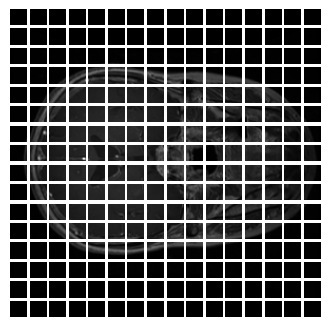

In [ ]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([rgb_images[0]]), size = (image_size, image_size)
)

patches = Patches(16)(resized_image)

print(f'Patch size: {16} X {16}')

print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (16, 16, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

###  Building and evaluating ViT model

In [ ]:
!pip install vit_keras

In [ ]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = (image_size, image_size),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False)

vit_model.summary()

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 16, 16, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 256, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 257, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 257, 768)          197376    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 257, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [ ]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(3, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
          

In [ ]:
checkpointer = ModelCheckpoint(filepath="vit_model.hdf5", verbose=2, save_best_only=True, monitor='val_loss')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='auto')

In [ ]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])


early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model.fit(x_train, y_train,
          validation_data = (x_test, y_test),
          epochs = 50,
          callbacks = [early_stopping_callbacks, checkpointer])

Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 1.0406 - accuracy: 0.5080
Epoch 1: val_loss improved from inf to 0.90760, saving model to vit_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 83s 671ms/step - loss: 1.0406 - accuracy: 0.5080 - val_loss: 0.9076 - val_accuracy: 0.6787
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.7937 - accuracy: 0.7618
Epoch 2: val_loss improved from 0.90760 to 0.79705, saving model to vit_model.hdf5
77/77 [==============================] - 48s 622ms/step - loss: 0.7937 - accuracy: 0.7618 - val_loss: 0.7971 - val_accuracy: 0.7574
Epoch 3/50
77/77 [==============================] - ETA: 0s - loss: 0.7303 - accuracy: 0.8212
Epoch 3: val_loss improved from 0.79705 to 0.72989, saving model to vit_model.hdf5
77/77 [==============================] - 48s 624ms/step - loss: 0.7303 - accuracy: 0.8212 - val_loss: 0.7299 - val_accuracy: 0.8311
Epoch 4/50
77/77 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.8581
Epoch 4: val_loss improved from 0.72989 to 0.67218, saving model to vit_model.hdf5
77/77 [==============================] - 48s 622ms/step - loss: 0.6827 - 

In [ ]:
model.load_weights('vit_model.hdf5')
pred = model.predict(x_test)

20/20 [==============================] - 6s 175ms/step


In [ ]:
y_true = np.argmax(y_test, axis=1)
pred = np.argmax(pred, axis=1)

print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       128
           1       0.95      0.95      0.95       304
           2       0.98      0.97      0.97       178

    accuracy                           0.94       610
   macro avg       0.93      0.93      0.93       610
weighted avg       0.94      0.94      0.94       610

